## Variant 1 (Fear Greed)

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Data Collection

In [4]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv("../Data/tickers.csv")

closing_prices = data["Adj Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

closing_prices.tail(10)

[*********************100%***********************]  7 of 7 completed


Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15 00:00:00+00:00,139.149994,149.970001,45.549953,333.645508,48.876144,22.830000,253.500000
2023-12-18 00:00:00+00:00,138.899994,154.070007,45.086166,343.308563,50.062801,23.799999,252.080002
2023-12-19 00:00:00+00:00,140.149994,153.789993,46.043346,349.026733,49.589939,24.350000,257.220001
2023-12-20 00:00:00+00:00,135.470001,152.119995,45.155243,347.950867,48.097359,23.180000,247.139999
2023-12-21 00:00:00+00:00,139.910004,153.839996,46.457798,352.742554,48.976116,23.580000,254.500000
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.045197,48.816162,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.479706,49.265030,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089161,356.468323,49.402988,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724056,356.956451,49.507965,23.540001,253.179993


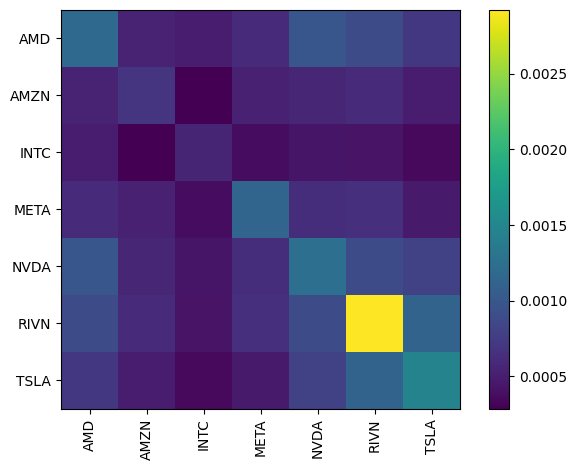

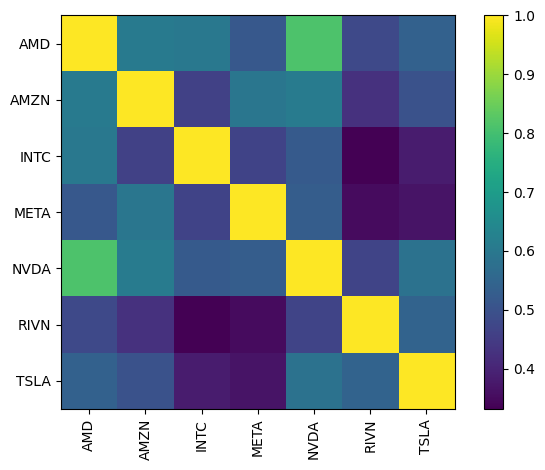

In [5]:
covariance_matrix = returns.cov()
covariance_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [6]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


### Get Prior and Delta

In [8]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

market_caps
market_prices

[*********************100%***********************]  1 of 1 completed


Date
2014-01-02    138.332779
2014-01-03    138.208984
2014-01-06    137.862396
2014-01-07    138.720612
2014-01-08    138.778366
                 ...    
2023-12-22    429.640320
2023-12-26    431.426788
2023-12-27    432.216400
2023-12-28    432.285522
2023-12-29    431.130676
Name: Adj Close, Length: 2516, dtype: float64

### Get Stock-Specific Fear-Greed Score
#### Calculate Relative Strength Index (RSI)

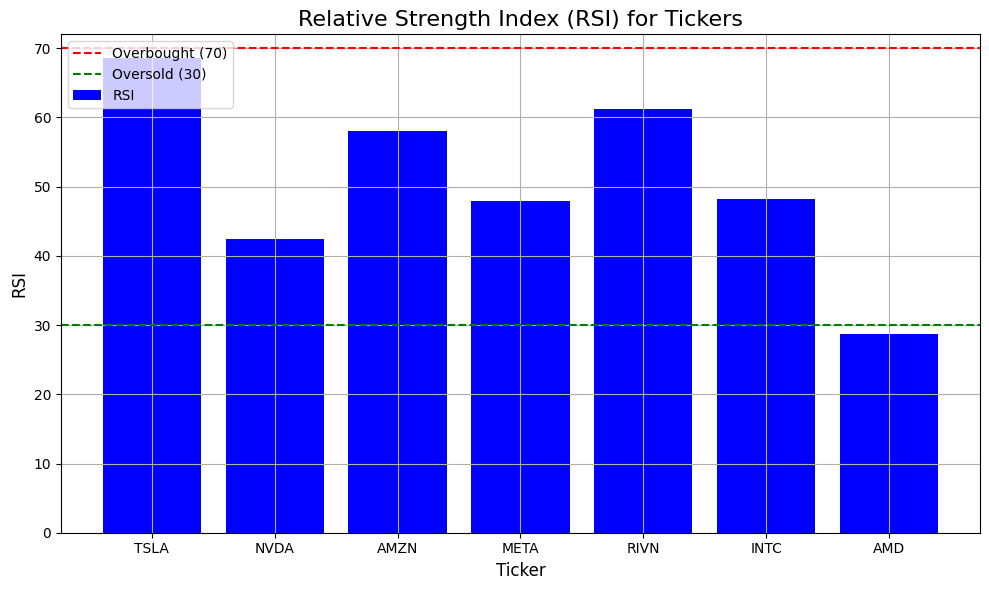

In [87]:
def calculate_stock_rsi(tickers, period=14):
    if not isinstance(tickers, list):
        print("tickers must be a list of strings")
        return None

    rsi_dict = {}
    for ticker in tickers:
        try:
            stock_data = yf.Ticker(ticker).history(period="1y")

            stock_data['Change'] = stock_data['Close'].diff()
            stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
            stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)
            stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
            stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()
            stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
            stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

            # latest rsi
            rsi_dict[ticker] = stock_data['RSI'].iloc[-1]
        
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating RSI")
            rsi_dict[ticker] = None

    return rsi_dict

def plot_stock_rsi(tickers, period=14):
    rsi_dict = calculate_stock_rsi(tickers, period)
    valid_rsi = {ticker: rsi for ticker, rsi in rsi_dict.items() if rsi is not None}

    if not valid_rsi:
        print("No valid RSI data available for plotting.")
        return

    # Create bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    tickers = list(valid_rsi.keys())
    rsi_values = list(valid_rsi.values())

    ax.bar(tickers, rsi_values, color='blue', label='RSI')
    ax.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax.axhline(30, color='green', linestyle='--', label='Oversold (30)')

    # Title and labels
    ax.set_title('Latest Relative Strength Index (RSI)', fontsize=16)
    ax.set_xlabel('Ticker', fontsize=12)
    ax.set_ylabel('RSI', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_stock_rsi(tickers)

#### Stock Price Strength

ValueError: not enough values to unpack (expected 5, got 4)

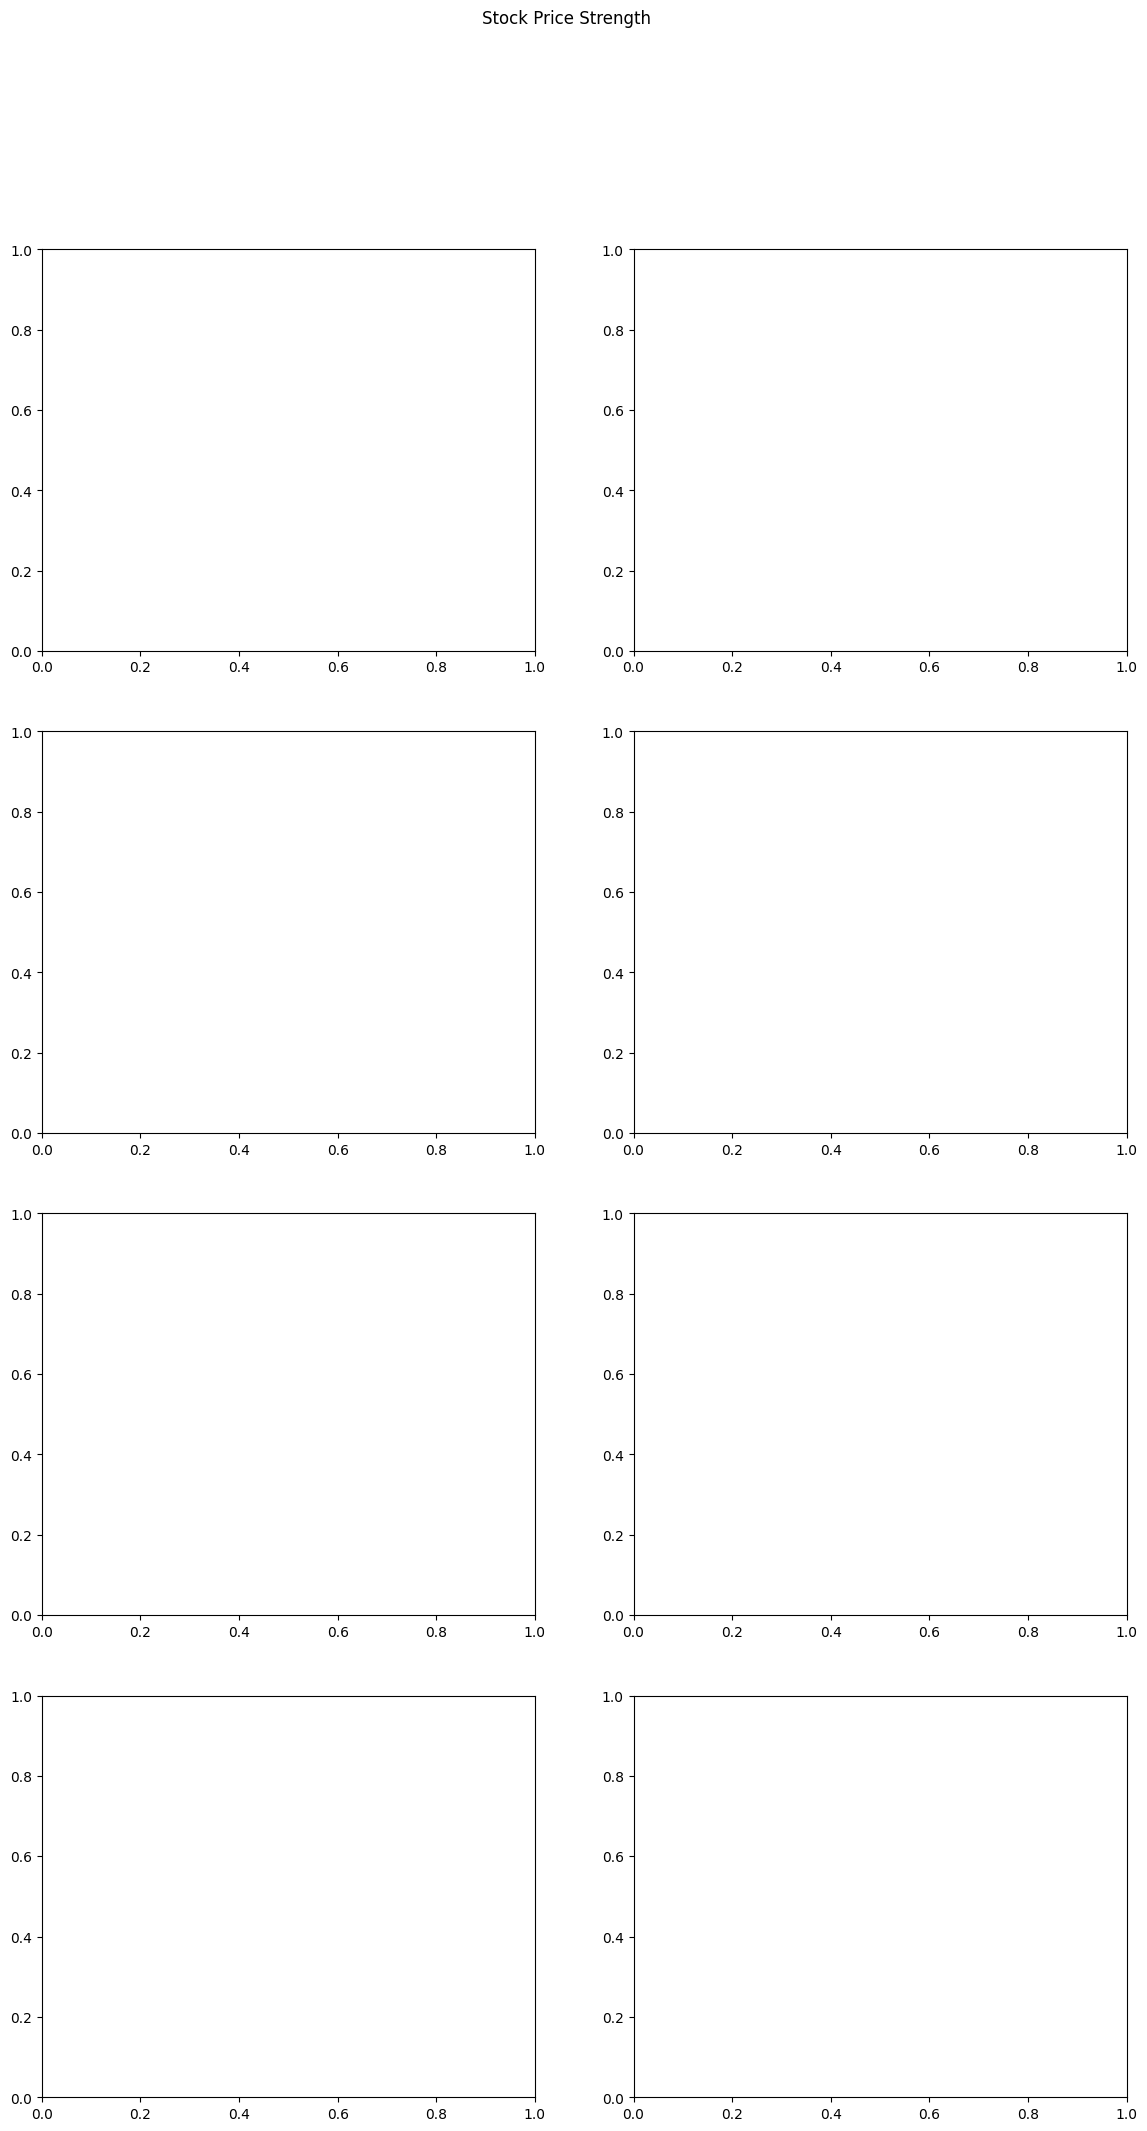

In [93]:
def calculate_stock_price_strength(tickers, period=52):
    price_strength_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")

            high = stock_data['High'].max()
            low = stock_data['Low'].min()
            current_price = stock_data['Close'].iloc[-1]

            #  proximity to 52-week high
            price_strength = (current_price - low) / (high - low) if high - low != 0 else None

            price_strength_dict[ticker] = (price_strength, high, low, current_price)

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating price strength")
            price_strength_dict[ticker] = None

    return price_strength_dict

def plot_stock_price_strength(tickers):
    nrows = (len(tickers) + 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(14, 6 * nrows), sharex=False)
    fig.suptitle('Stock Price Strength')
    axes = axes.flatten()

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        high, low, current_price, proximity_to_high, prior_year_history = calculate_stock_price_strength(ticker)

        if prior_year_history is not None:
            ax.plot(prior_year_history.index, prior_year_history['Close'], label='Close Price', color='blue')
            ax.axhline(high, color='red', linestyle='--', label='52-Week High')
            ax.axhline(low, color='green', linestyle='--', label='52-Week Low')
            ax.scatter(prior_year_history.index[-1], current_price, color='purple',label=f'Current Price (Proximity: {proximity_to_high:.2f})')

            ax.set_title(ticker, fontsize=14)
            ax.set_ylabel('Price', fontsize=12)
            ax.legend(loc='upper left')
            ax.grid(True)
        else:
            ax.set_title(f"{ticker} (Error)")
            ax.text(0.5, 0.5, "Error: Unable to fetch data", transform=ax.transAxes, fontsize=12, color="red", ha="center",va="center")
            ax.axis("off")

    for j in range(len(tickers), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_stock_price_strength(tickers)

#### Stock Price Breadth

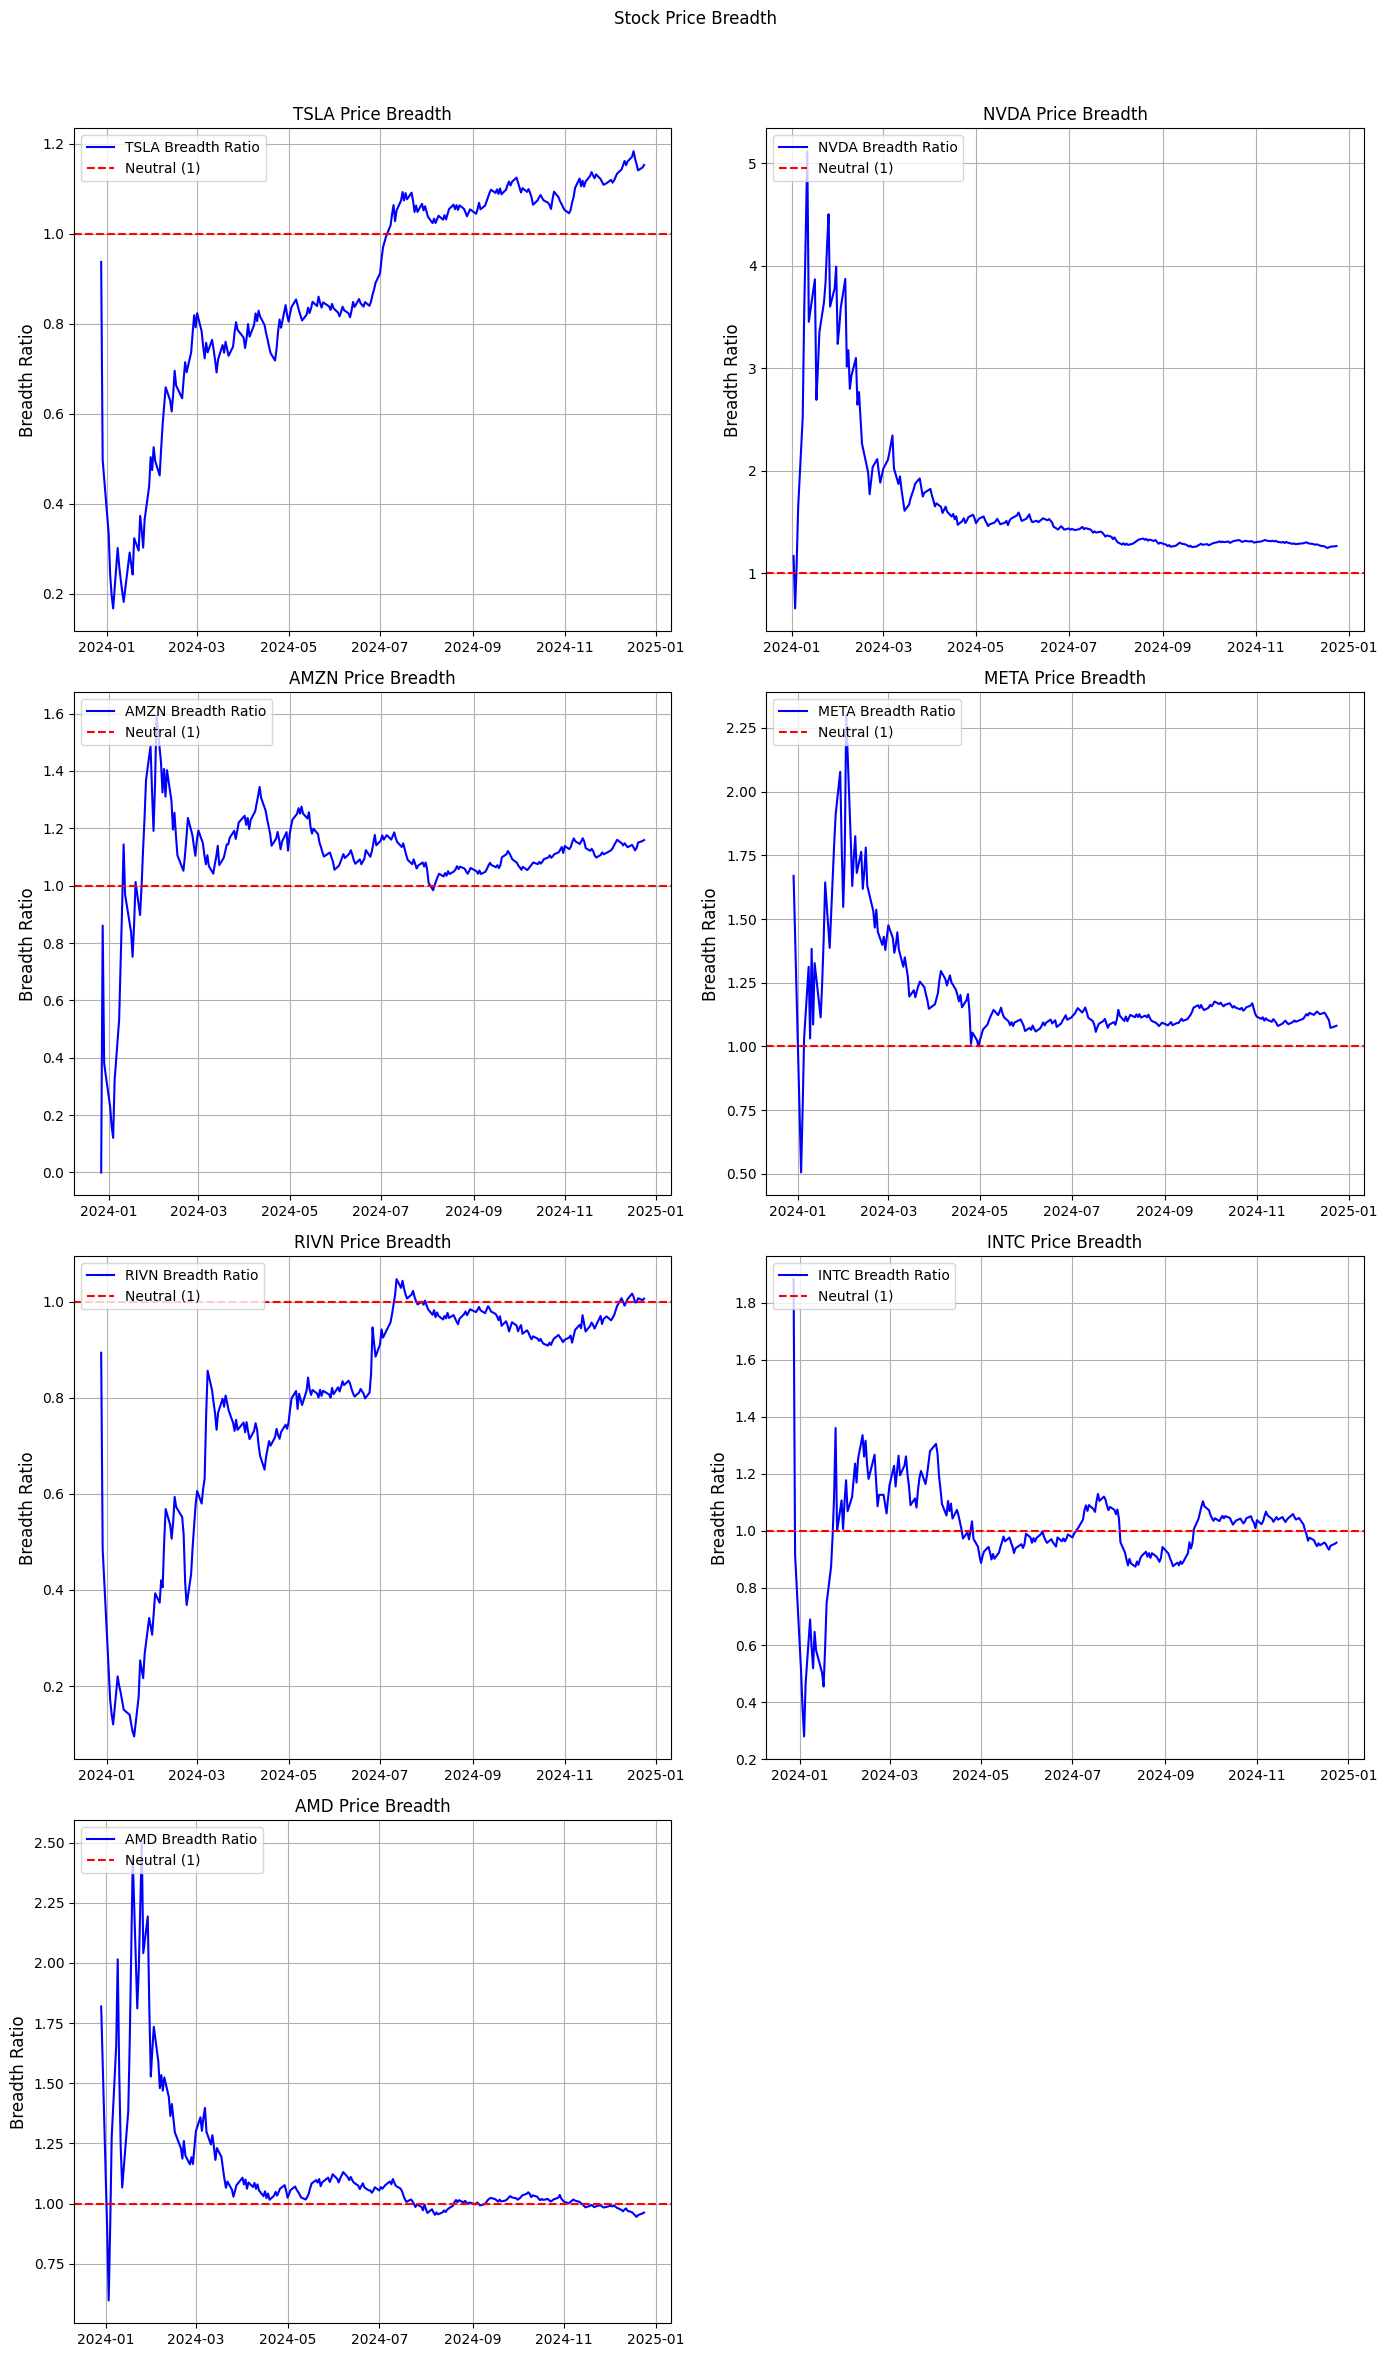

In [33]:
def calculate_stock_price_breadth(ticker):
    try:
        stock_data = yf.Ticker(ticker)
        prior_year_history = stock_data.history(period="1y")

        close_data = prior_year_history['Close'].tolist()
        volume_data = prior_year_history['Volume'].tolist()

        rising_vol = 0
        declining_vol = 0

        for i in range(1, len(close_data)):
            price_change = close_data[i] - close_data[i - 1]
            if price_change > 0:
                rising_vol += volume_data[i]
            elif price_change < 0:
                declining_vol += volume_data[i]
        if declining_vol == 0: # breadth ratio
            breadth_ratio = float('inf') if rising_vol > 0 else 0
        else:
            breadth_ratio = rising_vol / declining_vol

        return prior_year_history, rising_vol, declining_vol, breadth_ratio

    except Exception as error:
        print(f"An error occurred for {ticker}: {error} when calculating price breadth")
        return None, 0, 0, 0

def plot_stock_price_breadth(tickers):
    fig, axes = plt.subplots(
        nrows=(len(tickers) + 1) // 2, ncols=2, figsize=(14, 6 * ((len(tickers) + 1) // 2)), sharex=False
    )
    fig.suptitle('Stock Price Breadth')
    axes = axes.flatten()

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        prior_year_history, rising_vol, declining_vol, breadth_ratio = calculate_stock_price_breadth(ticker)

        if prior_year_history is not None:
            # daily breadth ratio over time
            close_data = prior_year_history['Close'].tolist()
            volume_data = prior_year_history['Volume'].tolist()

            daily_breadth_ratios = []
            rising_vol = 0
            declining_vol = 0

            for j in range(1, len(close_data)):
                price_change = close_data[j] - close_data[j - 1]
                if price_change > 0:
                    rising_vol += volume_data[j]
                elif price_change < 0:
                    declining_vol += volume_data[j]
                if declining_vol == 0:
                    daily_breadth_ratios.append(float('inf') if rising_vol > 0 else 0)
                else:
                    daily_breadth_ratios.append(rising_vol / declining_vol)

            ax.plot(prior_year_history.index[1:], daily_breadth_ratios, label=f"{ticker} Breadth Ratio", color="blue")
            ax.axhline(1, color="red", linestyle="--", label="Neutral (1)")
            ax.set_title(f"{ticker} Price Breadth")
            ax.set_ylabel("Breadth Ratio", fontsize=12)
            ax.legend(loc="upper left")
            ax.grid(True)
        else:
            ax.set_title(f"{ticker} (Error)")
            ax.text(0.5, 0.5, "Error: Unable to fetch data", transform=ax.transAxes, fontsize=12, color="red", ha="center",va="center")
            ax.axis("off")

    for j in range(len(tickers), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_stock_price_breadth(tickers)

#### Market Volatility

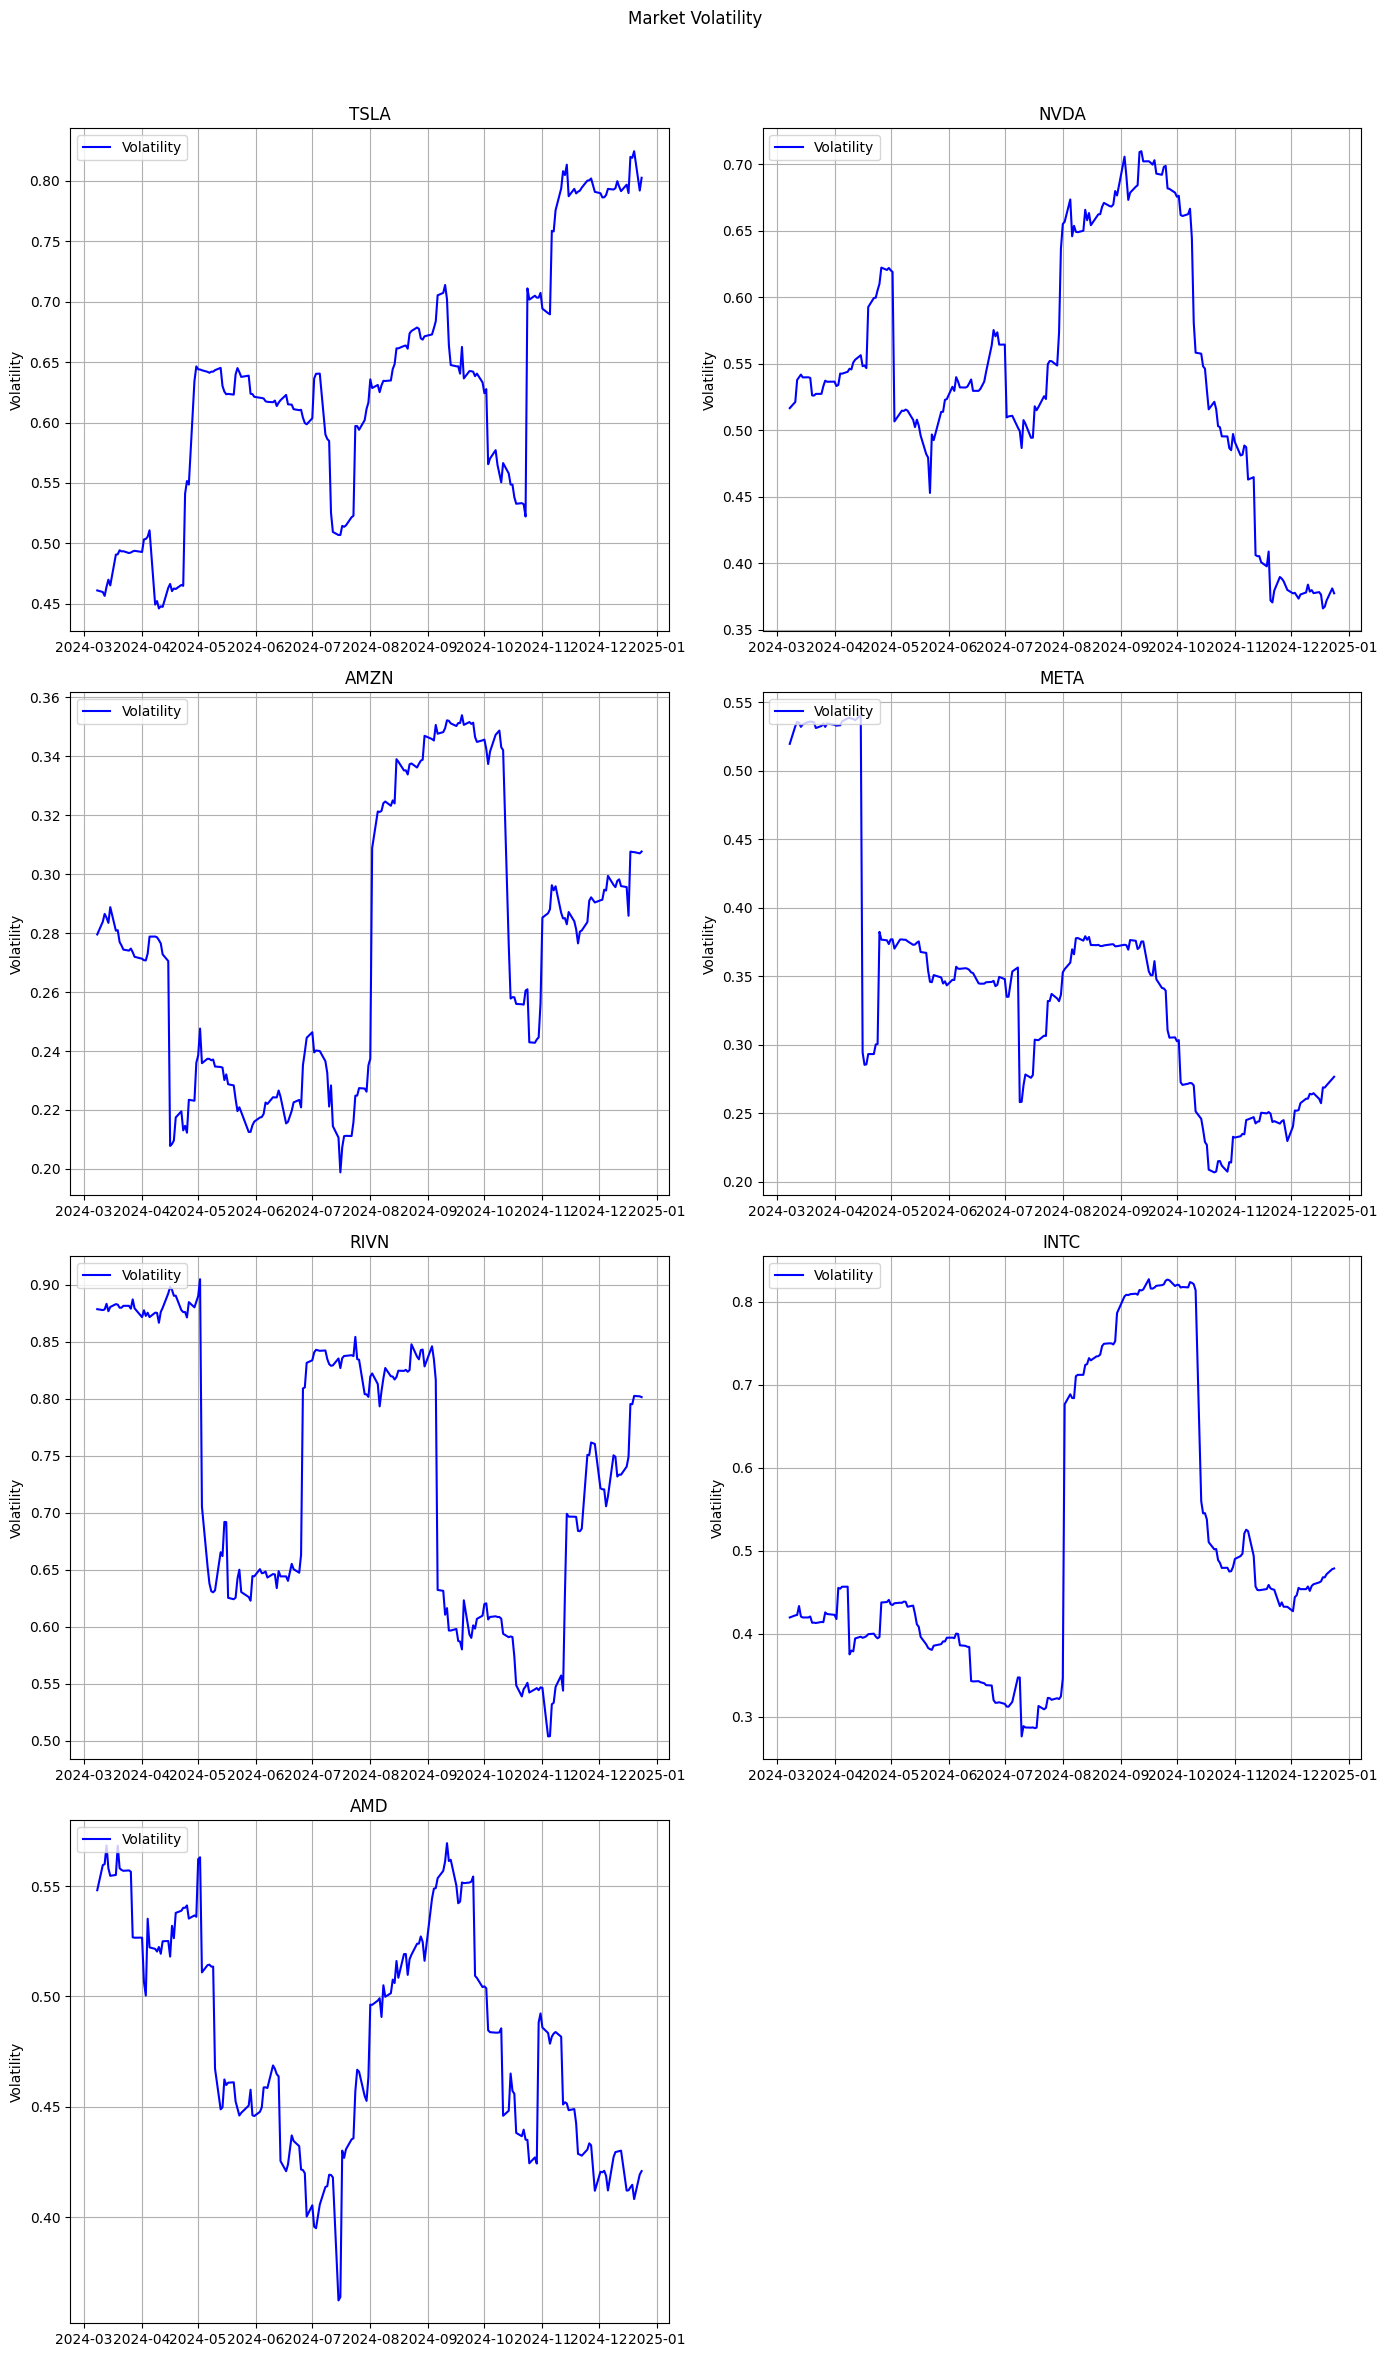

In [34]:
def calculate_market_volatility(ticker):    
    try:
        stock_data = yf.Ticker(ticker).history(period="1y")
        stock_data['Returns'] = stock_data['Close'].pct_change()
        stock_data['Volatility'] = stock_data['Returns'].rolling(window=50).std() * np.sqrt(252)
        latest_volatility = stock_data['Volatility'].iloc[-1]
        return stock_data['Volatility']
    
    except Exception as error:
        print(f"An error occurred for {ticker}: {error} when calculating volatility")
        return None

def plot_market_volatility(tickers):
    nrows = (len(tickers) + 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(14, 6 * nrows), sharex=False, sharey=False)
    fig.suptitle('Market Volatility')
    axes = axes.flatten()

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        volatility_data = calculate_market_volatility(ticker)

        if volatility_data is not None:
            ax.plot(volatility_data.index, volatility_data, label='Volatility', color='blue')
            ax.set_title(ticker)
            ax.set_ylabel('Volatility')
            ax.legend(loc='upper left')
            ax.grid(True)
        else:
            ax.set_title(f"{ticker} (Error)")
            ax.text(0.5, 0.5, "Error: Unable to fetch data", transform=ax.transAxes, fontsize=12, color="red", ha="center",va="center")
            ax.axis("off")

    # remove extra plots
    for j in range(len(tickers), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_market_volatility(tickers)

#### (Latest) Put-Call Ratio

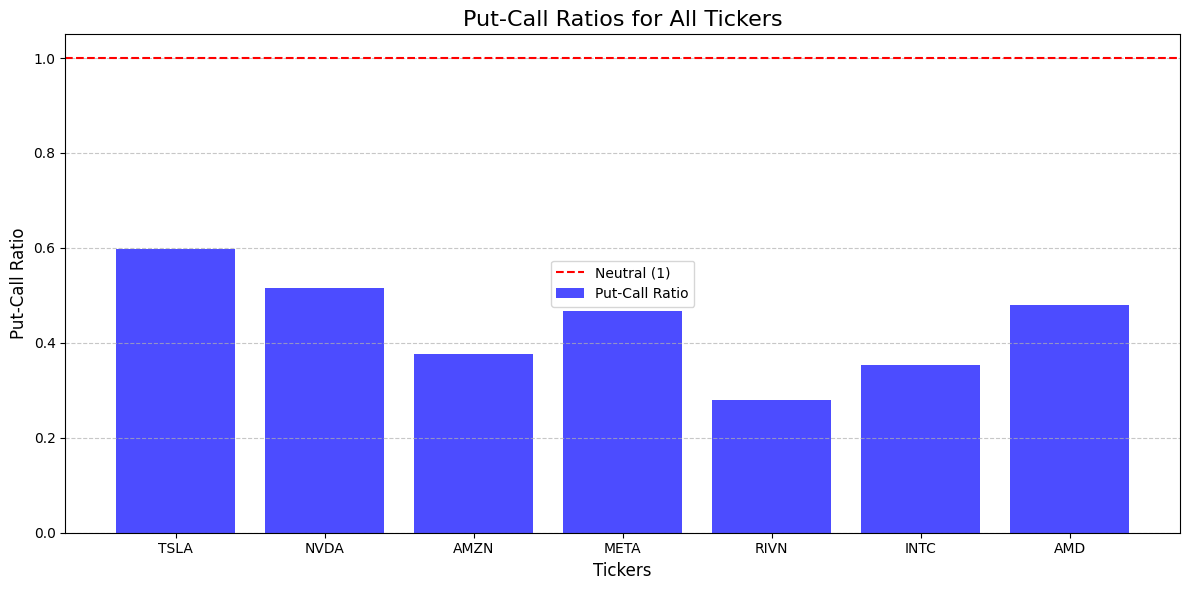

In [35]:
def calculate_put_call_ratio(ticker):
    try:
        # Get the options chain for the ticker
        options = yf.Ticker(ticker).option_chain()
        puts = options.puts
        calls = options.calls

        # Calculate total volumes
        total_put_volume = puts['volume'].sum()
        total_call_volume = calls['volume'].sum()

        # Calculate the Put-Call Ratio
        put_call_ratio = total_put_volume / total_call_volume if total_call_volume != 0 else None

        return put_call_ratio
    except Exception as error:
        print(f"An error occurred for {ticker}: {error} when calculating put-call ratio")
        return None

def plot_put_call_ratio(tickers):
    put_call_ratios = []

    for ticker in tickers:
        ratio = calculate_put_call_ratio(ticker)
        if ratio is not None:
            put_call_ratios.append((ticker, ratio))
        else:
            put_call_ratios.append((ticker, None))

    valid_data = [(ticker, ratio) for ticker, ratio in put_call_ratios if ratio is not None]
    tickers, ratios = zip(*valid_data) if valid_data else ([], [])

    plt.figure(figsize=(12, 6))
    plt.bar(tickers, ratios, color='blue', alpha=0.7, label='Put-Call Ratio')
    plt.axhline(1, color='red', linestyle='--', label='Neutral (1)')
    plt.title('Put-Call Ratios for All Tickers', fontsize=16)
    plt.xlabel('Tickers', fontsize=12)
    plt.ylabel('Put-Call Ratio', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_put_call_ratio(tickers)

In [92]:
# Get plain values

# rsi = calculate_stock_rsi(tickers)
# print(rsi)
# {'TSLA': 68.28914064682033, 'NVDA': 42.301405253907895, 'AMZN': 57.86984289725445, 'META': 47.717006505597574, 'RIVN': 61.171231252647495, 'INTC': 48.17047276950266, 'AMD': 28.619213431977144}

# strength = calculate_stock_price_strength(tickers)
# price_strength = {ticker: values[0] for ticker, values in strength.items()}
# print(price_strength)
# {'TSLA': 0.902727686290052, 'NVDA': 0.8710902524854324, 'AMZN': 0.9362000759251295, 'META': 0.8808261374188373, 'RIVN': 0.3543259088041256, 'INTC': 0.06434569192212818, 'AMD': 0.07248629062678683}


# NOT YET WORKING
# breadth = calculate_stock_price_breadth(tickers)
# breadth

# volatility = calculate_market_volatility(tickers)
# print(volatility)

# put_call = calculate_put_call_ratio(tickers)
# put_call

{'TSLA': 0.902727686290052, 'NVDA': 0.8710902524854324, 'AMZN': 0.9362000759251295, 'META': 0.8808261374188373, 'RIVN': 0.3543259088041256, 'INTC': 0.06434569192212818, 'AMD': 0.07248629062678683}


In [43]:
def get_fear_greed(tickers, start_date=None, end_date=None):
    fear_greed_scores_dict = {}

    for ticker in tickers:
        try:
            # Calculate each indicator for the stock
            rsi = calculate_stock_rsi(ticker)
            price_strength, _, _, _ = calculate_stock_price_strength(ticker)
            breadth_ratio = calculate_stock_price_breadth(ticker)
            volatility = calculate_market_volatility(ticker)
            put_call_ratio = calculate_put_call_ratio(ticker)

            # Normalize each indicator
            normalised_rsi = rsi / 100 if rsi is not None else 0.5
            normalised_price_strength = price_strength if price_strength is not None else 0.5
            normalised_breadth = min(max(breadth_ratio / 2, 0), 1) if breadth_ratio is not None else 0.5
            normalised_volatility = min(max(volatility / 100, 0), 1) if volatility is not None else 0.5
            normalised_put_call_ratio = (
                min(max(put_call_ratio, 0), 1) if put_call_ratio is not None else 0.5
            )

            # Assign weights to each indicator
            rsi_weight = 0.2
            price_strength_weight = 0.2
            breadth_weight = 0.2
            volatility_weight = 0.2
            put_call_ratio_weight = 0.2

            # Calculate the Fear-Greed score
            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight +
                normalised_volatility * volatility_weight +
                normalised_put_call_ratio * put_call_ratio_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when attempting to calculate the fear-greed score")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

In [44]:
fear_greed_scores_dict = get_fear_greed(tickers, start_date, end_date)
print(fear_greed_scores_dict)

$N: possibly delisted; no price data found  (period=1y)


An error occurred for TSLA: too many values to unpack (expected 4) when attempting to calculate the fear-greed score
An error occurred for NVDA: too many values to unpack (expected 4) when attempting to calculate the fear-greed score


$N: possibly delisted; no price data found  (period=1y)


An error occurred for AMZN: too many values to unpack (expected 4) when attempting to calculate the fear-greed score
An error occurred for META: too many values to unpack (expected 4) when attempting to calculate the fear-greed score


$I: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$N: possibly delisted; no price data found  (period=1y)


An error occurred for RIVN: too many values to unpack (expected 4) when attempting to calculate the fear-greed score


$I: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$N: possibly delisted; no price data found  (period=1y)


An error occurred for INTC: too many values to unpack (expected 4) when attempting to calculate the fear-greed score
An error occurred for AMD: too many values to unpack (expected 4) when attempting to calculate the fear-greed score
{'TSLA': None, 'NVDA': None, 'AMZN': None, 'META': None, 'RIVN': None, 'INTC': None, 'AMD': None}


### Convert to Views

In [33]:
bullish_threshold = 0.50 # this should ideally be 70+
bearish_threshold = 0.3

fg_based_views = {}
fg_based_confidences = {}

for ticker, score in fear_greed_scores.items():
    if score > bullish_threshold:
        view_returns = 0.02 + (score - bullish_threshold) * 0.0001
    elif score < bearish_threshold:
        view_returns = -0.02 + (bearish_threshold - score) * 0.0001
    else:
        view_returns = 0.0

    fg_based_views[ticker] = view_returns
    confidence = abs(score - 0.5) / 0.5
    fg_based_confidences[ticker] = confidence

fg_views_array = np.array([value for value in fg_based_views.values() if value != 0.0])
fg_confidences_array = np.array([value for value in fg_based_confidences.values() if value != 0.0])

print(f"Views: {fg_views_array}")
print(f"Confidences: {fg_confidences_array}")

Views: [0.02000545 0.02000553 0.02000139 0.02000624]
Confidences: [0.10890729 0.11065736 0.02783757 0.12484329 0.21277738 0.30515607
 0.22271652]


In [34]:
# views per ticker {'TSLA': 0.020004905972819897, 'NVDA': 0.020001646317597807, 'AMZN': 0.02000531466844215, 'META': 0.02000369495348263, 'RIVN': 0.0, 'INTC': 0.0, 'AMD': 0.0}
# tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

picking_matrix = np.array([ # picking matrix needs to be relative for each ticker (outperforming vs underperforming)
    [1, 0, 0, 0, 0, 0, 0],  # TSLA
    [0, 1, 0, 0, 0, 0, 0],  # NVDA
    [0, 0, 1, 0, 0, 0, 0],  # AMZN
    [0, 0, 0, 1, 0, 0, 0],  # META
])

fear_greed_bl = BlackLittermanModel(
    fg_covariance_matrix, 
    pi=prior,
    absolute_views=None,
    Q=fg_views_array,
    P=picking_matrix,
    omega="idzorek",
    view_confidences=fg_confidences_array,
    tau=0.025,
    risk_aversion=delta
)

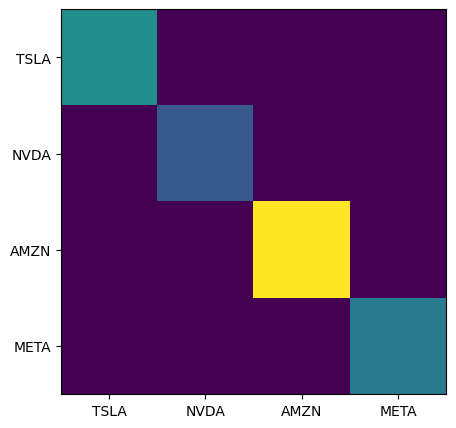

In [35]:
def plot_omega():
    tickers_with_views = ["TSLA", "NVDA", "AMZN", "META"]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(fear_greed_bl.omega)

    ax.set_xticks(np.arange(len(tickers_with_views)))
    ax.set_yticks(np.arange(len(tickers_with_views)))

    ax.set_xticklabels(tickers_with_views)
    ax.set_yticklabels(tickers_with_views)
    plt.show()

    np.diag(fear_greed_bl.omega)

plot_omega()

In [36]:
fear_greed_returns = fear_greed_bl.bl_returns()
fear_greed_returns

Ticker
AMD     0.022448
AMZN    0.021849
INTC    0.021182
META    0.022072
NVDA    0.022963
RIVN    0.022689
TSLA    0.022608
dtype: float64

In [37]:
views_vs_scores = pd.DataFrame([fear_greed_scores, fg_based_views, fg_based_confidences], index=["Fear-Greed Scores", "Views", "Confidences"]).T
views_vs_scores

,Fear-Greed Scores,Views,Confidences
TSLA,0.554454,0.020005,0.108907
NVDA,0.555329,0.020006,0.110657
AMZN,0.513919,0.020001,0.027838
META,0.562422,0.020006,0.124843
RIVN,0.393611,0.000000,0.212777
INTC,0.347422,0.000000,0.305156
AMD,0.388642,0.000000,0.222717


<Axes: >

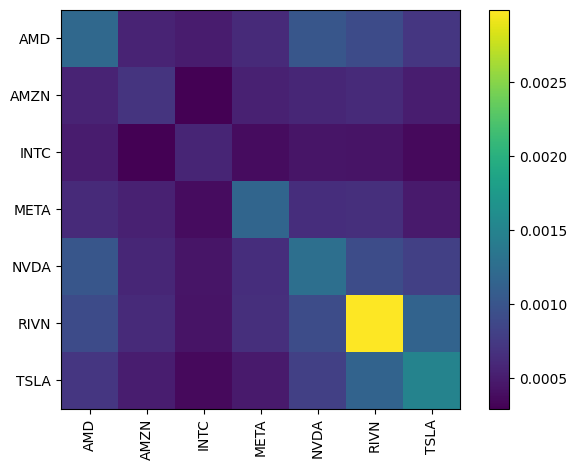

In [38]:
fg_posterior_cov = fear_greed_bl.bl_cov()
plotting.plot_covariance(fg_posterior_cov)

In [39]:
fg_ef = EfficientFrontier(fear_greed_returns, fg_posterior_cov)
min_vol_weights = fg_ef.min_volatility()
# max_sharpe_weights = fg_ef.max_sharpe() # max_sharpe not working. look into this

cleaned_weights = fg_ef.clean_weights()
cleaned_weights

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.37619),
             ('INTC', 0.57157),
             ('META', 0.01552),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.03672)])

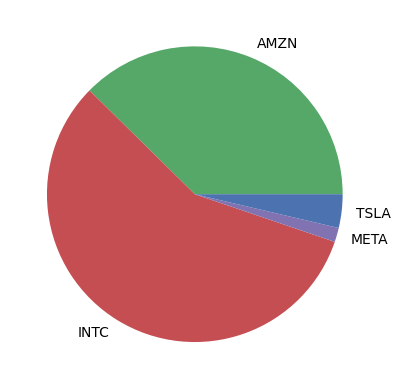

In [40]:
model_2_allocations = pd.Series(cleaned_weights).plot.pie()

In [41]:
fg_ef.portfolio_performance(verbose=True)

Expected annual return: 2.1%
Annual volatility: 2.1%
Sharpe Ratio: 0.07


(0.021498751266142733, 0.021385426631676224, 0.07008283219951164)

In [42]:
latest_prices = get_latest_prices(data)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

ValueError: Cannot broadcast dimensions  (7,) (42,)